In [1]:
# Basic
import numpy as np
import pandas as pd
import math
import logging


In [2]:
# NLP
import gensim
from gensim import corpora
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from collections import defaultdict



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [3]:
# Visualization
from wordcloud import WordCloud
import matplotlib
import matplotlib.pylab as plt
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [5]:
# Import data 
df = pd.read_csv('../data/AmNat_allAbstracts.csv')
df = df.dropna(subset=['Abstract'])

In [47]:
# Clean up texts
symbols = '.,?!-;*"…:—()%#$&_/@＼・'

def basic_preprocess(data):
    data = str(data)
    data = data.lower()

    def clean_special_chars(text, symbols):        
        for p in symbols:
            text = text.replace(p, ' ')
        return text

    data = clean_special_chars(data, symbols)
    return data

df['cleaned'] = df['Abstract'].apply(basic_preprocess)

In [48]:
# remove stop words
#list
all_text = list(df['cleaned'])

# filter stopwords & stem words
stop_words = set(stopwords.words())
texts = [[ps.stem(word) for word in document.lower().split() if word not in stop_words] for document in all_text]

# reduce memory
# del df
del all_text

In [65]:

# setting frequency
frequency = defaultdict(int)

# count the number of occurrences of the word
for text in texts:
    for token in text:
        frequency[token] += 1

# build only words above 30 into an array
texts = [[token for token in text if frequency[token] > 30] for text in texts]

In [66]:
# Build dictionary

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_above=0.8)

# vocab size
print('vocab size: ', len(dictionary))


2020-07-22 15:19:40,971 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-07-22 15:19:41,556 : INFO : built Dictionary(2564 unique tokens: ['accumul', 'adapt', 'affect', 'allel', 'caus']...) from 6636 documents (total 734797 corpus positions)
2020-07-22 15:19:41,558 : INFO : discarding 2 tokens: [('mhc', 4), ('divorc', 4)]...
2020-07-22 15:19:41,558 : INFO : keeping 2562 tokens which were in no less than 5 and no more than 5308 (=80.0%) documents
2020-07-22 15:19:41,560 : INFO : resulting dictionary: Dictionary(2562 unique tokens: ['accumul', 'adapt', 'affect', 'allel', 'caus']...)


vocab size:  2562


In [67]:
# Build corpus 
corpus = [dictionary.doc2bow(t) for t in texts]

# tfidf
tfidf = gensim.models.TfidfModel(corpus)

# make corpus_tfidf
corpus_tfidf = tfidf[corpus]

2020-07-22 15:19:43,779 : INFO : collecting document frequencies
2020-07-22 15:19:43,780 : INFO : PROGRESS: processing document #0
2020-07-22 15:19:43,847 : INFO : calculating IDF weights for 6636 documents and 2562 features (464928 matrix non-zeros)


In [59]:
# LDA model 
start = 5
limit = 25
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

  0%|          | 0/20 [00:00<?, ?it/s]2020-07-22 15:11:42,700 : INFO : using symmetric alpha at 0.2
2020-07-22 15:11:42,700 : INFO : using symmetric eta at 0.2
2020-07-22 15:11:42,702 : INFO : using serial LDA version on this node
2020-07-22 15:11:42,704 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:11:42,704 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-07-22 15:11:42,705 : INFO : PROGRESS: pass 0, at document #2000/6636
2020-07-22 15:11:44,157 : INFO : merging changes from 2000 documents into a model of 6636 documents
2020-07-22 15:11:44,159 : INFO : topic #0 (0.200): 0.009*"effect" + 0.008*"select" + 0.008*"speci" + 0.007*"increas" + 0.007*"popul" + 0.007*"ecolog" + 0.006*

2020-07-22 15:11:54,791 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:11:54,799 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:11:54,804 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:11:54,808 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 15:11:54,811 : INFO : 23 batches submitted to accumulate stats from 1472 documents (15822 virtual)
2020-07-22 15:11:54,818 : INFO : 24 batches submitted to accumulate stats from 1536 documents (16324 virtual)
2020-07-22 15:11:54,830 : INFO : 25 batches submitted to accumulate stats from 1600 documents (16566 virtual)
2020-07-22 15:11:54,844 : INFO : 26 batches submitted to accumulate stats from 1664 documents (16724 virtual)
2020-07-22 15:11:54,851 : INFO : 27 batches submitted to accumulate stats from 1728 documents (16912 virtual)
2020-07-22

2020-07-22 15:11:55,887 : INFO : accumulated word occurrence stats for 132180 virtual documents
  5%|▌         | 1/20 [00:13<04:14, 13.37s/it]2020-07-22 15:11:56,072 : INFO : using symmetric alpha at 0.16666666666666666
2020-07-22 15:11:56,072 : INFO : using symmetric eta at 0.16666666666666666
2020-07-22 15:11:56,074 : INFO : using serial LDA version on this node
2020-07-22 15:11:56,076 : INFO : running online (single-pass) LDA training, 6 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:11:56,077 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-07-22 15:11:56,079 : INFO : PROGRESS: pass 0, at document #2000/6636
2020-07-22 15:11:57,552 : INFO : merging changes from 2000 documents into a model of 6636 documents
2020-07-22 15:11:57,55

2020-07-22 15:12:08,084 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:12:08,087 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:12:08,091 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:12:08,098 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:12:08,109 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 15:12:08,116 : INFO : 23 batches submitted to accumulate stats from 1472 documents (15822 virtual)
2020-07-22 15:12:08,126 : INFO : 24 batches submitted to accumulate stats from 1536 documents (16324 virtual)
2020-07-22 15:12:08,129 : INFO : 25 batches submitted to accumulate stats from 1600 documents (16566 virtual)
2020-07-22 15:12:08,145 : INFO : 26 batches submitted to accumulate stats from 1664 documents (16724 virtual)
2020-07-22

2020-07-22 15:12:09,216 : INFO : accumulator serialized
2020-07-22 15:12:09,241 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:12:09,254 : INFO : accumulated word occurrence stats for 132185 virtual documents
 10%|█         | 2/20 [00:26<04:00, 13.38s/it]2020-07-22 15:12:09,471 : INFO : using symmetric alpha at 0.14285714285714285
2020-07-22 15:12:09,472 : INFO : using symmetric eta at 0.14285714285714285
2020-07-22 15:12:09,473 : INFO : using serial LDA version on this node
2020-07-22 15:12:09,477 : INFO : running online (single-pass) LDA training, 7 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:12:09,477 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-07-22 15:12:09,479 : INFO : PROGRESS: pass 0, at document #

2020-07-22 15:12:21,280 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:12:21,285 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:12:21,289 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:12:21,295 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:12:21,328 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:12:21,343 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 15:12:21,346 : INFO : 23 batches submitted to accumulate stats from 1472 documents (15822 virtual)
2020-07-22 15:12:21,352 : INFO : 24 batches submitted to accumulate stats from 1536 documents (16324 virtual)
2020-07-22 15:12:21,362 : INFO : 25 batches submitted to accumulate stats from 1600 documents (16566 virtual)
2020-07-22

2020-07-22 15:12:22,529 : INFO : serializing accumulator to return to master...
2020-07-22 15:12:22,534 : INFO : accumulator serialized
2020-07-22 15:12:22,562 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:12:22,575 : INFO : accumulated word occurrence stats for 132185 virtual documents
 15%|█▌        | 3/20 [00:40<03:47, 13.37s/it]2020-07-22 15:12:22,827 : INFO : using symmetric alpha at 0.125
2020-07-22 15:12:22,828 : INFO : using symmetric eta at 0.125
2020-07-22 15:12:22,830 : INFO : using serial LDA version on this node
2020-07-22 15:12:22,833 : INFO : running online (single-pass) LDA training, 8 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:12:22,834 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-07-22 1

2020-07-22 15:12:34,358 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:12:34,369 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:12:34,373 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:12:34,381 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:12:34,385 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:12:34,420 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:12:34,431 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 15:12:34,437 : INFO : 23 batches submitted to accumulate stats from 1472 documents (15822 virtual)
2020-07-22 15:12:34,447 : INFO : 24 batches submitted to accumulate stats from 1536 documents (16324 virtual)
2020-07-22

2020-07-22 15:12:35,768 : INFO : accumulator serialized
2020-07-22 15:12:35,783 : INFO : accumulator serialized
2020-07-22 15:12:35,846 : INFO : serializing accumulator to return to master...
2020-07-22 15:12:35,850 : INFO : accumulator serialized
2020-07-22 15:12:35,881 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:12:35,897 : INFO : accumulated word occurrence stats for 132185 virtual documents
 20%|██        | 4/20 [00:53<03:33, 13.37s/it]2020-07-22 15:12:36,181 : INFO : using symmetric alpha at 0.1111111111111111
2020-07-22 15:12:36,182 : INFO : using symmetric eta at 0.1111111111111111
2020-07-22 15:12:36,183 : INFO : using serial LDA version on this node
2020-07-22 15:12:36,187 : INFO : running online (single-pass) LDA training, 9 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:12:36,188 : WARNI

2020-07-22 15:12:47,827 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:12:47,863 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:12:47,867 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:12:47,880 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:12:47,884 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:12:47,887 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:12:47,927 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:12:47,930 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 15:12:47,939 : INFO : 23 batches submitted to accumulate stats from 1472 documents (15822 virtual)
2020-07-22 

2020-07-22 15:12:49,244 : INFO : serializing accumulator to return to master...
2020-07-22 15:12:49,219 : INFO : accumulator serialized
2020-07-22 15:12:49,219 : INFO : accumulator serialized
2020-07-22 15:12:49,273 : INFO : serializing accumulator to return to master...
2020-07-22 15:12:49,250 : INFO : accumulator serialized
2020-07-22 15:12:49,277 : INFO : accumulator serialized
2020-07-22 15:12:49,314 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:12:49,330 : INFO : accumulated word occurrence stats for 132185 virtual documents
 25%|██▌       | 5/20 [01:06<03:20, 13.40s/it]2020-07-22 15:12:49,649 : INFO : using symmetric alpha at 0.1
2020-07-22 15:12:49,649 : INFO : using symmetric eta at 0.1
2020-07-22 15:12:49,651 : INFO : using serial LDA version on this node
2020-07-22 15:12:49,655 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity e

2020-07-22 15:13:01,408 : INFO : 14 batches submitted to accumulate stats from 896 documents (10354 virtual)
2020-07-22 15:13:01,421 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:13:01,474 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:13:01,478 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:13:01,482 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:13:01,485 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:13:01,488 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:13:01,542 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:13:01,547 : INFO : 22 batches submitted to accumulate stats from 1408 documents (15195 virtual)
2020-07-22 1

2020-07-22 15:13:02,955 : INFO : accumulator serialized
2020-07-22 15:13:03,000 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:02,971 : INFO : accumulator serialized
2020-07-22 15:13:02,978 : INFO : accumulator serialized
2020-07-22 15:13:03,004 : INFO : accumulator serialized
2020-07-22 15:13:03,053 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:03,057 : INFO : accumulator serialized
2020-07-22 15:13:03,092 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:13:03,107 : INFO : accumulated word occurrence stats for 132186 virtual documents
 30%|███       | 6/20 [01:20<03:09, 13.52s/it]2020-07-22 15:13:03,449 : INFO : using symmetric alpha at 0.09090909090909091
2020-07-22 15:13:03,449 : INFO : using symmetric eta at 0.09090909090909091
2020-07-22 15:13:03,450 : INFO : using serial LDA version on this node
2020-07-22 15:13:03,456 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied cor

2020-07-22 15:13:15,249 : INFO : 13 batches submitted to accumulate stats from 832 documents (9851 virtual)
2020-07-22 15:13:15,253 : INFO : 14 batches submitted to accumulate stats from 896 documents (10354 virtual)
2020-07-22 15:13:15,256 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:13:15,298 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:13:15,309 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:13:15,312 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:13:15,315 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:13:15,326 : INFO : 20 batches submitted to accumulate stats from 1280 documents (13842 virtual)
2020-07-22 15:13:15,374 : INFO : 21 batches submitted to accumulate stats from 1344 documents (14390 virtual)
2020-07-22 15:

2020-07-22 15:13:16,907 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:16,933 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:16,907 : INFO : accumulator serialized
2020-07-22 15:13:16,912 : INFO : accumulator serialized
2020-07-22 15:13:16,940 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:16,938 : INFO : accumulator serialized
2020-07-22 15:13:16,945 : INFO : accumulator serialized
2020-07-22 15:13:16,995 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:16,999 : INFO : accumulator serialized
2020-07-22 15:13:17,038 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:13:17,055 : INFO : accumulated word occurrence stats for 132186 virtual documents
 35%|███▌      | 7/20 [01:34<02:57, 13.66s/it]2020-07-22 15:13:17,437 : INFO : using symmetric alpha at 0.08333333333333333
2020-07-22 15:13:17,437 : INFO : using symmetric eta at 0.08333333333333333
2020-07-22 15:13:17,439 : IN

2020-07-22 15:13:28,996 : INFO : 11 batches submitted to accumulate stats from 704 documents (8632 virtual)
2020-07-22 15:13:29,006 : INFO : 12 batches submitted to accumulate stats from 768 documents (9092 virtual)
2020-07-22 15:13:29,009 : INFO : 13 batches submitted to accumulate stats from 832 documents (9851 virtual)
2020-07-22 15:13:29,015 : INFO : 14 batches submitted to accumulate stats from 896 documents (10354 virtual)
2020-07-22 15:13:29,030 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:13:29,090 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:13:29,097 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:13:29,107 : INFO : 18 batches submitted to accumulate stats from 1152 documents (12727 virtual)
2020-07-22 15:13:29,110 : INFO : 19 batches submitted to accumulate stats from 1216 documents (13128 virtual)
2020-07-22 15:13:2

2020-07-22 15:13:30,764 : INFO : 104 batches submitted to accumulate stats from 6656 documents (48782 virtual)
2020-07-22 15:13:30,880 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:30,899 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:30,883 : INFO : accumulator serialized
2020-07-22 15:13:30,922 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:30,943 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:30,907 : INFO : accumulator serialized
2020-07-22 15:13:30,931 : INFO : accumulator serialized
2020-07-22 15:13:30,948 : INFO : accumulator serialized
2020-07-22 15:13:31,004 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:31,008 : INFO : accumulator serialized
2020-07-22 15:13:31,052 : INFO : 5 accumulators retrieved from output queue
2020-07-22 15:13:31,070 : INFO : accumulated word occurrence stats for 132186 virtual documents
 40%|████      | 8/20 [01:48<02:45, 1

2020-07-22 15:13:43,036 : INFO : 9 batches submitted to accumulate stats from 576 documents (7773 virtual)
2020-07-22 15:13:43,045 : INFO : 10 batches submitted to accumulate stats from 640 documents (8089 virtual)
2020-07-22 15:13:43,077 : INFO : 11 batches submitted to accumulate stats from 704 documents (8632 virtual)
2020-07-22 15:13:43,088 : INFO : 12 batches submitted to accumulate stats from 768 documents (9092 virtual)
2020-07-22 15:13:43,091 : INFO : 13 batches submitted to accumulate stats from 832 documents (9851 virtual)
2020-07-22 15:13:43,108 : INFO : 14 batches submitted to accumulate stats from 896 documents (10354 virtual)
2020-07-22 15:13:43,112 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:13:43,170 : INFO : 16 batches submitted to accumulate stats from 1024 documents (11554 virtual)
2020-07-22 15:13:43,182 : INFO : 17 batches submitted to accumulate stats from 1088 documents (12122 virtual)
2020-07-22 15:13:43,186

2020-07-22 15:13:44,790 : INFO : 98 batches submitted to accumulate stats from 6272 documents (49299 virtual)
2020-07-22 15:13:44,876 : INFO : 103 batches submitted to accumulate stats from 6592 documents (47988 virtual)
2020-07-22 15:13:44,880 : INFO : 104 batches submitted to accumulate stats from 6656 documents (48782 virtual)
2020-07-22 15:13:45,000 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:45,018 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:45,036 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:45,004 : INFO : accumulator serialized
2020-07-22 15:13:45,064 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:45,024 : INFO : accumulator serialized
2020-07-22 15:13:45,041 : INFO : accumulator serialized
2020-07-22 15:13:45,067 : INFO : accumulator serialized
2020-07-22 15:13:45,124 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:45,129 : INFO : accumulator

2020-07-22 15:13:57,365 : INFO : 7 batches submitted to accumulate stats from 448 documents (6124 virtual)
2020-07-22 15:13:57,377 : INFO : 8 batches submitted to accumulate stats from 512 documents (6979 virtual)
2020-07-22 15:13:57,384 : INFO : 9 batches submitted to accumulate stats from 576 documents (7773 virtual)
2020-07-22 15:13:57,397 : INFO : 10 batches submitted to accumulate stats from 640 documents (8089 virtual)
2020-07-22 15:13:57,425 : INFO : 11 batches submitted to accumulate stats from 704 documents (8632 virtual)
2020-07-22 15:13:57,432 : INFO : 12 batches submitted to accumulate stats from 768 documents (9092 virtual)
2020-07-22 15:13:57,441 : INFO : 13 batches submitted to accumulate stats from 832 documents (9851 virtual)
2020-07-22 15:13:57,454 : INFO : 14 batches submitted to accumulate stats from 896 documents (10354 virtual)
2020-07-22 15:13:57,457 : INFO : 15 batches submitted to accumulate stats from 960 documents (11031 virtual)
2020-07-22 15:13:57,513 : INF

2020-07-22 15:13:58,894 : INFO : 86 batches submitted to accumulate stats from 5504 documents (57516 virtual)
2020-07-22 15:13:58,941 : INFO : 88 batches submitted to accumulate stats from 5632 documents (58060 virtual)
2020-07-22 15:13:59,142 : INFO : 98 batches submitted to accumulate stats from 6272 documents (49299 virtual)
2020-07-22 15:13:59,232 : INFO : 103 batches submitted to accumulate stats from 6592 documents (47988 virtual)
2020-07-22 15:13:59,235 : INFO : 104 batches submitted to accumulate stats from 6656 documents (48782 virtual)
2020-07-22 15:13:59,355 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:59,374 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:59,391 : INFO : serializing accumulator to return to master...
2020-07-22 15:13:59,358 : INFO : accumulator serialized
2020-07-22 15:13:59,378 : INFO : accumulator serialized
2020-07-22 15:13:59,428 : INFO : serializing accumulator to return to master...
2020-07-22 15:13

2020-07-22 15:14:11,804 : INFO : 5 batches submitted to accumulate stats from 320 documents (4670 virtual)
2020-07-22 15:14:11,811 : INFO : 6 batches submitted to accumulate stats from 384 documents (5306 virtual)
2020-07-22 15:14:11,822 : INFO : 7 batches submitted to accumulate stats from 448 documents (6124 virtual)
2020-07-22 15:14:11,837 : INFO : 8 batches submitted to accumulate stats from 512 documents (6979 virtual)
2020-07-22 15:14:11,850 : INFO : 9 batches submitted to accumulate stats from 576 documents (7773 virtual)
2020-07-22 15:14:11,858 : INFO : 10 batches submitted to accumulate stats from 640 documents (8089 virtual)
2020-07-22 15:14:11,889 : INFO : 11 batches submitted to accumulate stats from 704 documents (8632 virtual)
2020-07-22 15:14:11,898 : INFO : 12 batches submitted to accumulate stats from 768 documents (9092 virtual)
2020-07-22 15:14:11,902 : INFO : 13 batches submitted to accumulate stats from 832 documents (9851 virtual)
2020-07-22 15:14:11,917 : INFO : 

2020-07-22 15:14:13,255 : INFO : 81 batches submitted to accumulate stats from 5184 documents (57748 virtual)
2020-07-22 15:14:13,264 : INFO : 83 batches submitted to accumulate stats from 5312 documents (57596 virtual)
2020-07-22 15:14:13,374 : INFO : 86 batches submitted to accumulate stats from 5504 documents (57516 virtual)
2020-07-22 15:14:13,406 : INFO : 88 batches submitted to accumulate stats from 5632 documents (58060 virtual)
2020-07-22 15:14:13,603 : INFO : 98 batches submitted to accumulate stats from 6272 documents (49299 virtual)
2020-07-22 15:14:13,693 : INFO : 103 batches submitted to accumulate stats from 6592 documents (47988 virtual)
2020-07-22 15:14:13,697 : INFO : 104 batches submitted to accumulate stats from 6656 documents (48782 virtual)
2020-07-22 15:14:13,833 : INFO : serializing accumulator to return to master...
2020-07-22 15:14:13,848 : INFO : serializing accumulator to return to master...
2020-07-22 15:14:13,878 : INFO : serializing accumulator to return t

2020-07-22 15:14:26,323 : INFO : 3 batches submitted to accumulate stats from 192 documents (2604 virtual)
2020-07-22 15:14:26,328 : INFO : 4 batches submitted to accumulate stats from 256 documents (3640 virtual)
2020-07-22 15:14:26,333 : INFO : 5 batches submitted to accumulate stats from 320 documents (4670 virtual)
2020-07-22 15:14:26,346 : INFO : 6 batches submitted to accumulate stats from 384 documents (5306 virtual)
2020-07-22 15:14:26,362 : INFO : 7 batches submitted to accumulate stats from 448 documents (6124 virtual)
2020-07-22 15:14:26,369 : INFO : 8 batches submitted to accumulate stats from 512 documents (6979 virtual)
2020-07-22 15:14:26,378 : INFO : 9 batches submitted to accumulate stats from 576 documents (7773 virtual)
2020-07-22 15:14:26,389 : INFO : 10 batches submitted to accumulate stats from 640 documents (8089 virtual)
2020-07-22 15:14:26,853 : INFO : 11 batches submitted to accumulate stats from 704 documents (8632 virtual)
2020-07-22 15:14:26,857 : INFO : 12

2020-07-22 15:14:28,275 : INFO : 79 batches submitted to accumulate stats from 5056 documents (55257 virtual)
2020-07-22 15:14:28,317 : INFO : 80 batches submitted to accumulate stats from 5120 documents (57295 virtual)
2020-07-22 15:14:28,320 : INFO : 81 batches submitted to accumulate stats from 5184 documents (57748 virtual)
2020-07-22 15:14:28,361 : INFO : 83 batches submitted to accumulate stats from 5312 documents (57596 virtual)
2020-07-22 15:14:28,465 : INFO : 86 batches submitted to accumulate stats from 5504 documents (57516 virtual)
2020-07-22 15:14:28,520 : INFO : 88 batches submitted to accumulate stats from 5632 documents (58060 virtual)
2020-07-22 15:14:28,747 : INFO : 98 batches submitted to accumulate stats from 6272 documents (49299 virtual)
2020-07-22 15:14:28,834 : INFO : 103 batches submitted to accumulate stats from 6592 documents (47988 virtual)
2020-07-22 15:14:28,850 : INFO : 104 batches submitted to accumulate stats from 6656 documents (48782 virtual)
2020-07-

2020-07-22 15:14:41,641 : INFO : 1 batches submitted to accumulate stats from 64 documents (879 virtual)
2020-07-22 15:14:41,649 : INFO : 2 batches submitted to accumulate stats from 128 documents (1939 virtual)
2020-07-22 15:14:41,653 : INFO : 3 batches submitted to accumulate stats from 192 documents (2604 virtual)
2020-07-22 15:14:41,658 : INFO : 4 batches submitted to accumulate stats from 256 documents (3640 virtual)
2020-07-22 15:14:41,663 : INFO : 5 batches submitted to accumulate stats from 320 documents (4670 virtual)
2020-07-22 15:14:41,667 : INFO : 6 batches submitted to accumulate stats from 384 documents (5306 virtual)
2020-07-22 15:14:41,677 : INFO : 7 batches submitted to accumulate stats from 448 documents (6124 virtual)
2020-07-22 15:14:41,690 : INFO : 8 batches submitted to accumulate stats from 512 documents (6979 virtual)
2020-07-22 15:14:41,708 : INFO : 9 batches submitted to accumulate stats from 576 documents (7773 virtual)
2020-07-22 15:14:41,728 : INFO : 10 bat

2020-07-22 15:14:43,269 : INFO : 77 batches submitted to accumulate stats from 4928 documents (53715 virtual)
2020-07-22 15:14:43,323 : INFO : 78 batches submitted to accumulate stats from 4992 documents (55072 virtual)
2020-07-22 15:14:43,331 : INFO : 79 batches submitted to accumulate stats from 5056 documents (55257 virtual)
2020-07-22 15:14:43,382 : INFO : 80 batches submitted to accumulate stats from 5120 documents (57295 virtual)
2020-07-22 15:14:43,404 : INFO : 81 batches submitted to accumulate stats from 5184 documents (57748 virtual)
2020-07-22 15:14:43,465 : INFO : 83 batches submitted to accumulate stats from 5312 documents (57596 virtual)
2020-07-22 15:14:43,552 : INFO : 86 batches submitted to accumulate stats from 5504 documents (57516 virtual)
2020-07-22 15:14:43,617 : INFO : 88 batches submitted to accumulate stats from 5632 documents (58060 virtual)
2020-07-22 15:14:43,870 : INFO : 98 batches submitted to accumulate stats from 6272 documents (49299 virtual)
2020-07-22

2020-07-22 15:14:56,775 : INFO : using ParallelWordOccurrenceAccumulator(processes=5, batch_size=64) to estimate probabilities from sliding windows
2020-07-22 15:14:56,825 : INFO : 1 batches submitted to accumulate stats from 64 documents (879 virtual)
2020-07-22 15:14:56,833 : INFO : 2 batches submitted to accumulate stats from 128 documents (1939 virtual)
2020-07-22 15:14:56,837 : INFO : 3 batches submitted to accumulate stats from 192 documents (2604 virtual)
2020-07-22 15:14:56,843 : INFO : 4 batches submitted to accumulate stats from 256 documents (3640 virtual)
2020-07-22 15:14:56,849 : INFO : 5 batches submitted to accumulate stats from 320 documents (4670 virtual)
2020-07-22 15:14:56,861 : INFO : 6 batches submitted to accumulate stats from 384 documents (5182 virtual)
2020-07-22 15:14:56,866 : INFO : 7 batches submitted to accumulate stats from 448 documents (6031 virtual)
2020-07-22 15:14:56,870 : INFO : 8 batches submitted to accumulate stats from 512 documents (6846 virtual

2020-07-22 15:14:58,446 : INFO : 76 batches submitted to accumulate stats from 4864 documents (52853 virtual)
2020-07-22 15:14:58,472 : INFO : 77 batches submitted to accumulate stats from 4928 documents (53528 virtual)
2020-07-22 15:14:58,510 : INFO : 78 batches submitted to accumulate stats from 4992 documents (54914 virtual)
2020-07-22 15:14:58,530 : INFO : 79 batches submitted to accumulate stats from 5056 documents (55019 virtual)
2020-07-22 15:14:58,583 : INFO : 80 batches submitted to accumulate stats from 5120 documents (57157 virtual)
2020-07-22 15:14:58,590 : INFO : 81 batches submitted to accumulate stats from 5184 documents (57611 virtual)
2020-07-22 15:14:58,643 : INFO : 83 batches submitted to accumulate stats from 5312 documents (57254 virtual)
2020-07-22 15:14:58,691 : INFO : 84 batches submitted to accumulate stats from 5376 documents (57326 virtual)
2020-07-22 15:14:58,744 : INFO : 86 batches submitted to accumulate stats from 5504 documents (57372 virtual)
2020-07-22

2020-07-22 15:15:05,827 : INFO : topic #11 (0.053): 0.047*"male" + 0.046*"femal" + 0.033*"mate" + 0.011*"stock" + 0.009*"sperm" + 0.008*"model" + 0.008*"fertil" + 0.008*"may" + 0.007*"egg" + 0.007*"increas"
2020-07-22 15:15:05,828 : INFO : topic diff=0.891138, rho=0.500000
2020-07-22 15:15:12,350 : INFO : -7.446 per-word bound, 174.3 perplexity estimate based on a held-out corpus of 6636 documents with 768303 words
2020-07-22 15:15:12,355 : INFO : using ParallelWordOccurrenceAccumulator(processes=5, batch_size=64) to estimate probabilities from sliding windows
2020-07-22 15:15:12,403 : INFO : 1 batches submitted to accumulate stats from 64 documents (879 virtual)
2020-07-22 15:15:12,409 : INFO : 2 batches submitted to accumulate stats from 128 documents (1939 virtual)
2020-07-22 15:15:12,414 : INFO : 3 batches submitted to accumulate stats from 192 documents (2604 virtual)
2020-07-22 15:15:12,418 : INFO : 4 batches submitted to accumulate stats from 256 documents (3640 virtual)
2020-07

2020-07-22 15:15:13,858 : INFO : 72 batches submitted to accumulate stats from 4608 documents (49173 virtual)
2020-07-22 15:15:13,891 : INFO : 73 batches submitted to accumulate stats from 4672 documents (50299 virtual)
2020-07-22 15:15:13,917 : INFO : 74 batches submitted to accumulate stats from 4736 documents (51434 virtual)
2020-07-22 15:15:13,979 : INFO : 75 batches submitted to accumulate stats from 4800 documents (51793 virtual)
2020-07-22 15:15:13,992 : INFO : 76 batches submitted to accumulate stats from 4864 documents (52982 virtual)
2020-07-22 15:15:14,006 : INFO : 77 batches submitted to accumulate stats from 4928 documents (53715 virtual)
2020-07-22 15:15:14,059 : INFO : 78 batches submitted to accumulate stats from 4992 documents (55072 virtual)
2020-07-22 15:15:14,094 : INFO : 79 batches submitted to accumulate stats from 5056 documents (55257 virtual)
2020-07-22 15:15:14,138 : INFO : 80 batches submitted to accumulate stats from 5120 documents (57295 virtual)
2020-07-22

2020-07-22 15:15:21,539 : INFO : topic #17 (0.050): 0.019*"speci" + 0.012*"rate" + 0.011*"cell" + 0.007*"increas" + 0.006*"segment" + 0.006*"result" + 0.006*"commun" + 0.006*"abnorm" + 0.005*"scale" + 0.005*"pattern"
2020-07-22 15:15:21,540 : INFO : topic #13 (0.050): 0.038*"plant" + 0.017*"speci" + 0.009*"competit" + 0.009*"may" + 0.008*"model" + 0.007*"use" + 0.006*"interact" + 0.006*"differ" + 0.006*"seed" + 0.006*"herbivor"
2020-07-22 15:15:21,541 : INFO : topic diff=0.917231, rho=0.500000
2020-07-22 15:15:27,915 : INFO : -7.459 per-word bound, 175.9 perplexity estimate based on a held-out corpus of 6636 documents with 768303 words
2020-07-22 15:15:27,919 : INFO : using ParallelWordOccurrenceAccumulator(processes=5, batch_size=64) to estimate probabilities from sliding windows
2020-07-22 15:15:27,970 : INFO : 1 batches submitted to accumulate stats from 64 documents (879 virtual)
2020-07-22 15:15:27,977 : INFO : 2 batches submitted to accumulate stats from 128 documents (1939 virtu

2020-07-22 15:15:29,596 : INFO : 70 batches submitted to accumulate stats from 4480 documents (46964 virtual)
2020-07-22 15:15:29,631 : INFO : 71 batches submitted to accumulate stats from 4544 documents (47868 virtual)
2020-07-22 15:15:29,640 : INFO : 72 batches submitted to accumulate stats from 4608 documents (49056 virtual)
2020-07-22 15:15:29,680 : INFO : 73 batches submitted to accumulate stats from 4672 documents (50036 virtual)
2020-07-22 15:15:29,702 : INFO : 74 batches submitted to accumulate stats from 4736 documents (51182 virtual)
2020-07-22 15:15:29,765 : INFO : 75 batches submitted to accumulate stats from 4800 documents (51477 virtual)
2020-07-22 15:15:29,788 : INFO : 76 batches submitted to accumulate stats from 4864 documents (52853 virtual)
2020-07-22 15:15:29,806 : INFO : 77 batches submitted to accumulate stats from 4928 documents (53528 virtual)
2020-07-22 15:15:29,866 : INFO : 78 batches submitted to accumulate stats from 4992 documents (54914 virtual)
2020-07-22

2020-07-22 15:15:37,394 : INFO : topic #10 (0.048): 0.025*"male" + 0.019*"femal" + 0.012*"hybrid" + 0.012*"speci" + 0.011*"select" + 0.011*"white" + 0.010*"strain" + 0.010*"cross" + 0.008*"differ" + 0.007*"two"
2020-07-22 15:15:37,394 : INFO : topic #9 (0.048): 0.017*"cell" + 0.017*"speci" + 0.016*"resourc" + 0.014*"competit" + 0.011*"stock" + 0.011*"predat" + 0.010*"system" + 0.009*"two" + 0.009*"model" + 0.008*"nutrient"
2020-07-22 15:15:37,395 : INFO : topic #18 (0.048): 0.019*"speci" + 0.013*"model" + 0.013*"prey" + 0.012*"distribut" + 0.010*"size" + 0.009*"densiti" + 0.009*"popul" + 0.008*"effect" + 0.007*"predat" + 0.007*"gener"
2020-07-22 15:15:37,396 : INFO : topic #14 (0.048): 0.027*"speci" + 0.010*"differ" + 0.009*"size" + 0.008*"factor" + 0.007*"pattern" + 0.007*"geograph" + 0.006*"famili" + 0.006*"hereditari" + 0.006*"suggest" + 0.006*"distribut"
2020-07-22 15:15:37,396 : INFO : topic diff=0.945575, rho=0.500000
2020-07-22 15:15:43,667 : INFO : -7.469 per-word bound, 177.2 

2020-07-22 15:15:45,077 : INFO : 66 batches submitted to accumulate stats from 4224 documents (40335 virtual)
2020-07-22 15:15:45,132 : INFO : 67 batches submitted to accumulate stats from 4288 documents (41530 virtual)
2020-07-22 15:15:45,135 : INFO : 68 batches submitted to accumulate stats from 4352 documents (44197 virtual)
2020-07-22 15:15:45,173 : INFO : 69 batches submitted to accumulate stats from 4416 documents (45295 virtual)
2020-07-22 15:15:45,177 : INFO : 70 batches submitted to accumulate stats from 4480 documents (47097 virtual)
2020-07-22 15:15:45,200 : INFO : 71 batches submitted to accumulate stats from 4544 documents (48287 virtual)
2020-07-22 15:15:45,238 : INFO : 72 batches submitted to accumulate stats from 4608 documents (49173 virtual)
2020-07-22 15:15:45,252 : INFO : 73 batches submitted to accumulate stats from 4672 documents (50299 virtual)
2020-07-22 15:15:45,294 : INFO : 74 batches submitted to accumulate stats from 4736 documents (51434 virtual)
2020-07-22

2020-07-22 15:15:52,962 : INFO : topic #3 (0.045): 0.014*"differ" + 0.012*"select" + 0.009*"charact" + 0.008*"size" + 0.008*"genet" + 0.008*"speci" + 0.008*"variat" + 0.008*"line" + 0.007*"may" + 0.007*"chang"
2020-07-22 15:15:52,963 : INFO : topic #14 (0.045): 0.033*"speci" + 0.010*"size" + 0.010*"distribut" + 0.009*"charact" + 0.008*"pattern" + 0.008*"differ" + 0.008*"factor" + 0.006*"form" + 0.006*"island" + 0.006*"length"
2020-07-22 15:15:52,964 : INFO : topic #2 (0.045): 0.021*"chromosom" + 0.019*"sex" + 0.011*"gene" + 0.011*"femal" + 0.011*"male" + 0.010*"ratio" + 0.008*"speci" + 0.008*"white" + 0.008*"1" + 0.008*"two"
2020-07-22 15:15:52,964 : INFO : topic #17 (0.045): 0.018*"cell" + 0.014*"rate" + 0.013*"speci" + 0.008*"increas" + 0.008*"abnorm" + 0.007*"growth" + 0.006*"model" + 0.005*"hereditari" + 0.005*"correl" + 0.005*"organ"
2020-07-22 15:15:52,965 : INFO : topic #1 (0.045): 0.015*"rang" + 0.013*"speci" + 0.012*"size" + 0.011*"model" + 0.011*"popul" + 0.010*"differ" + 0.0

2020-07-22 15:16:00,859 : INFO : 64 batches submitted to accumulate stats from 4096 documents (37989 virtual)
2020-07-22 15:16:00,888 : INFO : 65 batches submitted to accumulate stats from 4160 documents (39330 virtual)
2020-07-22 15:16:00,930 : INFO : 66 batches submitted to accumulate stats from 4224 documents (40335 virtual)
2020-07-22 15:16:00,954 : INFO : 67 batches submitted to accumulate stats from 4288 documents (41530 virtual)
2020-07-22 15:16:00,976 : INFO : 68 batches submitted to accumulate stats from 4352 documents (44197 virtual)
2020-07-22 15:16:01,001 : INFO : 69 batches submitted to accumulate stats from 4416 documents (45295 virtual)
2020-07-22 15:16:01,005 : INFO : 70 batches submitted to accumulate stats from 4480 documents (47097 virtual)
2020-07-22 15:16:01,062 : INFO : 71 batches submitted to accumulate stats from 4544 documents (48287 virtual)
2020-07-22 15:16:01,072 : INFO : 72 batches submitted to accumulate stats from 4608 documents (49173 virtual)
2020-07-22

2020-07-22 15:16:08,465 : INFO : PROGRESS: pass 0, at document #6636/6636
2020-07-22 15:16:08,898 : INFO : merging changes from 636 documents into a model of 6636 documents
2020-07-22 15:16:08,902 : INFO : topic #14 (0.043): 0.022*"speci" + 0.015*"charact" + 0.008*"differ" + 0.008*"size" + 0.007*"form" + 0.007*"factor" + 0.007*"group" + 0.006*"pattern" + 0.006*"studi" + 0.006*"horn"
2020-07-22 15:16:08,903 : INFO : topic #2 (0.043): 0.028*"chromosom" + 0.017*"sex" + 0.016*"gene" + 0.012*"male" + 0.011*"femal" + 0.009*"1" + 0.009*"ratio" + 0.008*"2" + 0.008*"color" + 0.007*"speci"
2020-07-22 15:16:08,904 : INFO : topic #16 (0.043): 0.015*"egg" + 0.012*"breed" + 0.011*"femal" + 0.009*"reproduct" + 0.008*"differ" + 0.008*"sex" + 0.007*"individu" + 0.007*"product" + 0.006*"1" + 0.006*"ratio"
2020-07-22 15:16:08,904 : INFO : topic #21 (0.043): 0.009*"food" + 0.008*"special" + 0.008*"size" + 0.008*"feed" + 0.008*"metamorphosi" + 0.008*"speci" + 0.007*"habit" + 0.005*"bird" + 0.005*"use" + 0.

2020-07-22 15:16:16,764 : INFO : 63 batches submitted to accumulate stats from 4032 documents (37715 virtual)
2020-07-22 15:16:16,767 : INFO : 64 batches submitted to accumulate stats from 4096 documents (37989 virtual)
2020-07-22 15:16:16,788 : INFO : 65 batches submitted to accumulate stats from 4160 documents (39330 virtual)
2020-07-22 15:16:16,841 : INFO : 66 batches submitted to accumulate stats from 4224 documents (40335 virtual)
2020-07-22 15:16:16,871 : INFO : 67 batches submitted to accumulate stats from 4288 documents (41530 virtual)
2020-07-22 15:16:16,885 : INFO : 68 batches submitted to accumulate stats from 4352 documents (44197 virtual)
2020-07-22 15:16:16,904 : INFO : 69 batches submitted to accumulate stats from 4416 documents (45295 virtual)
2020-07-22 15:16:16,921 : INFO : 70 batches submitted to accumulate stats from 4480 documents (47097 virtual)
2020-07-22 15:16:16,979 : INFO : 71 batches submitted to accumulate stats from 4544 documents (48287 virtual)
2020-07-22

2020-07-22 15:16:23,845 : INFO : topic diff=1.043873, rho=0.577350
2020-07-22 15:16:24,439 : INFO : -8.947 per-word bound, 493.6 perplexity estimate based on a held-out corpus of 636 documents with 64058 words
2020-07-22 15:16:24,439 : INFO : PROGRESS: pass 0, at document #6636/6636
2020-07-22 15:16:24,868 : INFO : merging changes from 636 documents into a model of 6636 documents
2020-07-22 15:16:24,872 : INFO : topic #8 (0.042): 0.015*"pollen" + 0.013*"select" + 0.012*"seed" + 0.012*"individu" + 0.011*"self" + 0.009*"cross" + 0.008*"flower" + 0.008*"1" + 0.008*"coloni" + 0.007*"mate"
2020-07-22 15:16:24,873 : INFO : topic #12 (0.042): 0.032*"habitat" + 0.016*"patch" + 0.011*"popul" + 0.010*"life" + 0.010*"speci" + 0.010*"local" + 0.009*"rate" + 0.009*"blood" + 0.009*"type" + 0.008*"product"
2020-07-22 15:16:24,874 : INFO : topic #21 (0.042): 0.013*"food" + 0.011*"fruit" + 0.010*"size" + 0.010*"gland" + 0.008*"feed" + 0.008*"speci" + 0.008*"embryo" + 0.007*"adult" + 0.007*"larval" + 0.

2020-07-22 15:16:32,686 : INFO : 61 batches submitted to accumulate stats from 3904 documents (37234 virtual)
2020-07-22 15:16:32,720 : INFO : 62 batches submitted to accumulate stats from 3968 documents (37407 virtual)
2020-07-22 15:16:32,733 : INFO : 63 batches submitted to accumulate stats from 4032 documents (37715 virtual)
2020-07-22 15:16:32,764 : INFO : 64 batches submitted to accumulate stats from 4096 documents (37989 virtual)
2020-07-22 15:16:32,808 : INFO : 65 batches submitted to accumulate stats from 4160 documents (39330 virtual)
2020-07-22 15:16:32,832 : INFO : 66 batches submitted to accumulate stats from 4224 documents (40335 virtual)
2020-07-22 15:16:32,888 : INFO : 67 batches submitted to accumulate stats from 4288 documents (41530 virtual)
2020-07-22 15:16:32,892 : INFO : 68 batches submitted to accumulate stats from 4352 documents (44197 virtual)
2020-07-22 15:16:32,898 : INFO : 69 batches submitted to accumulate stats from 4416 documents (45295 virtual)
2020-07-22

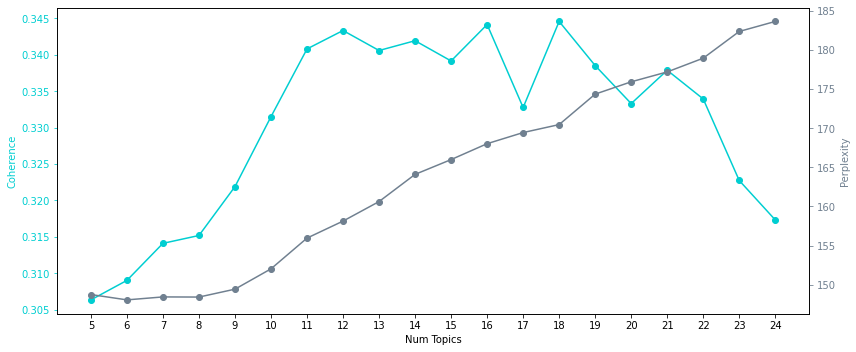

<Figure size 432x288 with 0 Axes>

In [60]:
# evaluation
x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

plt.savefig('metrics.png') 

In [68]:
# LDA Model
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=12, alpha='symmetric', random_state=0)


2020-07-22 15:19:53,377 : INFO : using symmetric alpha at 0.08333333333333333
2020-07-22 15:19:53,378 : INFO : using symmetric eta at 0.08333333333333333
2020-07-22 15:19:53,380 : INFO : using serial LDA version on this node
2020-07-22 15:19:53,382 : INFO : running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 6636 documents, updating model once every 2000 documents, evaluating perplexity every 6636 documents, iterating 50x with a convergence threshold of 0.001000
2020-07-22 15:19:53,383 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-07-22 15:19:53,383 : INFO : PROGRESS: pass 0, at document #2000/6636
2020-07-22 15:19:54,894 : INFO : merging changes from 2000 documents into a model of 6636 documents
2020-07-22 15:19:54,897 : INFO : topic #0 (0.083): 0.015*"speci" + 0.011*"host" + 0.009*"parasit" + 0.009*"effect" + 0.009*"differ" + 0.008*"popul" + 0.008*"model"

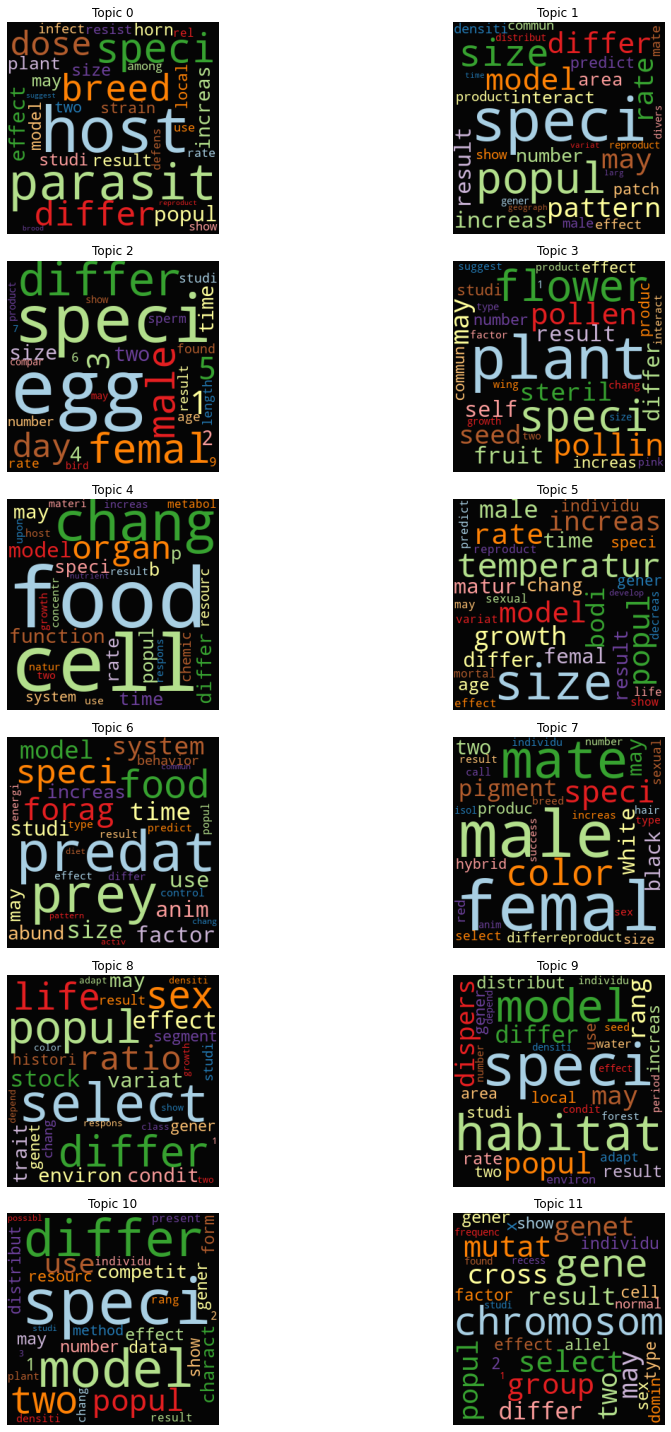

<Figure size 432x288 with 0 Axes>

In [72]:
# WordCloud


fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda_model.num_topics/2), figsize=(16,20))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        background_color='black',
        color_func=color_func,
        max_words=4000,
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

# vis
plt.tight_layout()
plt.show()

# save as png
plt.savefig('wordcloud.png') 

In [70]:
# Vis PCoA
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

# save as html
pyLDAvis.save_html(vis_pcoa, 'pyldavis_output_pcoa.html')